$Yμ∼N(μ,σ2)=α+β1X1+β2X2$


We set priors for parameters.
$α∼N(0,100) \\
βi∼N(0,100) \\
σ∼|N(0,1)|$


In [38]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

# set seed
np.random.seed(123)

# true values 
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100


X1 = np.random.randn(size)
X2 = np.random.randn(size)*0.2
# tuple is immutable object with ()
# list is mutable obj with []
# dict is {}, key chain value. Hash map maybe.

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [39]:
print(X1[:6],X2[:6])

[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654] [ 0.12841094 -0.39557759  0.14245293  0.51966079 -0.0049252   0.00682843]


In [40]:
print(Y[:6])

[0.93870686 0.41029615 3.83981292 1.48115418 0.40277951 2.4618453 ]


Text(0.5, 0, 'X2')

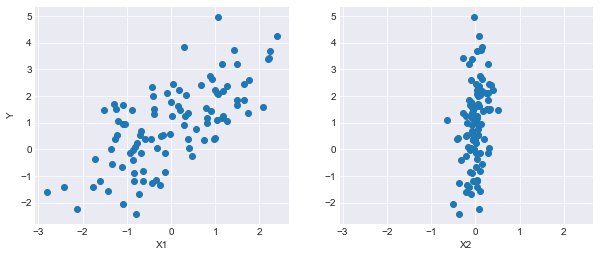

In [41]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharex = True, figsize = (10,4))
axes[0].scatter(X1,Y)
axes[1].scatter(X2,Y)
axes[0].set_xlabel("X1"); axes[0].set_ylabel("Y"); axes[1].set_xlabel("X2")

Here we generated data set from predetermined parameters, alpha, betas and sigma.

In [42]:
import pymc3 as pm


In [43]:
print('Running on pyMC3 v{}'.format(pm.__version__))

Running on pyMC3 v3.7


In [44]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta= pm.Normal('beta',mu=0,sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    
    # Expected value of outcome
    mu = alpha +beta[0]*X1 +beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal(name = 'Y_obs', mu = mu, sigma = sigma, observed = Y)

In [45]:
map_estimate=pm.find_MAP(model = basic_model)

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1642.05it/s]  


In [127]:
map_estimate

{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

So they are my posterior modes. Note that behind the scenes, pymc3 makes another variables from purely positive priors by logarithm. This allows the sampling more robust. For other variables having two boundaries such as beta or uniform, logit transformation is conducted.
If the posterier joint distribution is not symmetric, then modes of the distribution would be differ from the means of the distribution. Moreover, we do not have a credintial interval information. To obtain the information, we need further analysis.

We use Python with script. We use Ipython as command line method. We use Jupyter Notebook as another way.
Magic function with % or %% allows us to add more functionality on our basic codes. e.g. timeit gives us the time taken, and matplotlib inline gives us matplotlib mode where the plot comes to frontend and can be processed seamlessly.

If you are writing a script (.py file), then you need to end the file with plt.show() so that when you excute the file so could get all the active figures. Use this for only one time session.



## Q1.
This is from the tutorial webpage:  
It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; **with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.**

MAP will only find a local optimum. I believe that this implies the general possibility that if the posterior density is not convex.

# Sampling Methods

The fundemental idea is that under certain conditions, a Markov chain of values are approximately same as the sample values from the posterior density which is hard to get closed form of it.  
Step method object corresponds to the specific MCMC algorithms; 
1.Metropolis,  
2.Slice sampling,  
3.NUTS,  
4.HamiltonianMC,  
5.BinaryMetropolis.  
Automatic assignments are Metropolis for discrete variables and NUTS for continuous variables.  

## Gradiant Based Sampling Methods
### Basic Idea of NUTS
NUTS achieves its fast sampling speed by looking at gradiant of the posterior densities. By that reason this method is not available to be applied to discrete variables as they are not continuous, hence not differentiable. But it doesn't matter that some of the other variables are discrete when applying NUTS for a set of variables.

NUTS has a scaling matrix parameter. The speed of convergence of NUTS depends on the matrix parameter. If they are too small, we may neeed to wait for a long time. The matrix is analogous to the variance parameter for some  other method, Metropolis-Hasting.

There is a tuning phase where we can get proper scaling matrix parameter values.

I am getting sense that if I do not understand the methods of MCMC, just leave it to default so that pymc3 will choose the proper one for the matter.

In [47]:
with basic_model:
    trace=pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1256.27draws/s]


[sigma, beta, alpha] they are the names of parameters that we defined their prior distribution inside of the basic_model construction. 

In [48]:
trace

<MultiTrace: 2 chains, 500 iterations, 4 variables>

In [49]:
trace.varnames

['alpha', 'beta', 'sigma_log__', 'sigma']

In [50]:
trace['sigma_log__'][-5:]

array([-0.04848925,  0.04594924, -0.09549104, -0.03018122, -0.06721452])

## Q2: 
**I do not understand why we have sigma_log__ here**  
pm, pymc3 is a package. model is a class. basic_model is an object and we constructed the object putting random variables (alpha, beta, sigma, mu) and likelihood object. Then we put sample function from the pymc3 package into the basic_model object? I am wondering how the 'with' a model is relating the sample function with our model object. It seems sample function is not a method of a model object. correct?    
from the tutorial:  
The sample function runs the step method(s) assigned (or passed) to **it (what is 'it'? model object? no from the pymc3 document there is no sample method inside of model object)** for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. ...  
**The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. (what do you mean here?)**  
sample method is from sampling package or class or module (.py file which contains classes, functions and fields).   
**how can I easily see the relative location of a function or object ? for example, from pymc3.sampling.sample, how can I know if sampling is a module or class? (I guess it cannot be a sub-package since if so there should be a module (.py file) which contains sample function.

In [51]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

In [52]:
trace.report

In [53]:
trace.chains

[0, 1]

In [54]:
trace.get_sampler_stats

<bound method MultiTrace.get_sampler_stats of <MultiTrace: 2 chains, 500 iterations, 4 variables>>

In [55]:
trace.get_values

<bound method MultiTrace.get_values of <MultiTrace: 2 chains, 500 iterations, 4 variables>>

In [56]:
trace.nchains

2

In [57]:
trace.point

<bound method MultiTrace.point of <MultiTrace: 2 chains, 500 iterations, 4 variables>>

In [58]:
trace.points

<bound method MultiTrace.points of <MultiTrace: 2 chains, 500 iterations, 4 variables>>

In [59]:
# if we wanted to use slice to get sigma samples (why sigma?)
with basic_model:
    # instantiate sampler (we call this algorithm object sampler...)
    slice = pm.Slice()
    
    trace2 = pm.sample(5000, step = slice)

    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:11<00:00, 962.07draws/s] 


In [60]:
trace2.varnames

['alpha', 'beta', 'sigma_log__', 'sigma']

In [61]:
trace2['sigma_log__'][-5:]

array([ 0.08047848,  0.04747047, -0.00060263, -0.05639208, -0.03209541])

If we wanted to use the slice sampling algorithm to **sigma (WHY SIGMA ONLY?)** instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

In [62]:
# run it if you don't have the package
# pip install arviz


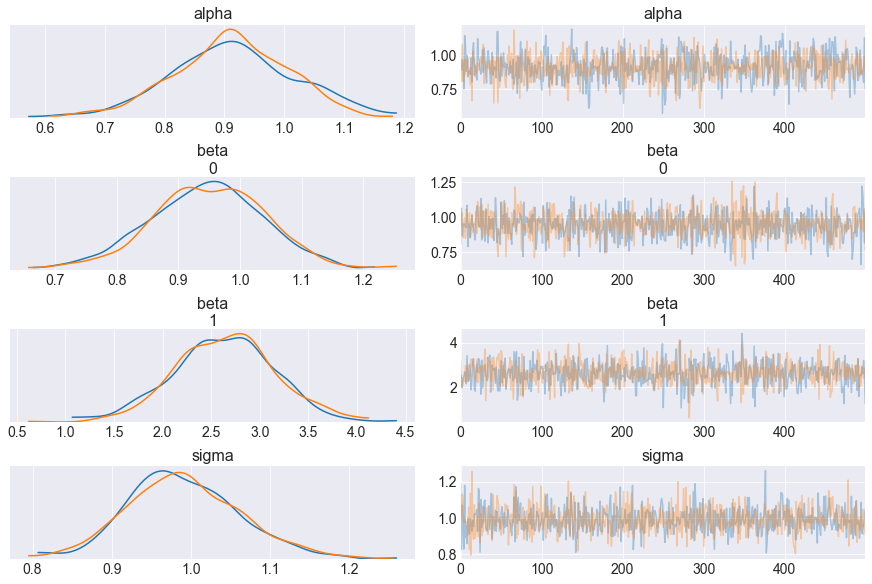

In [63]:
pm.traceplot(trace);

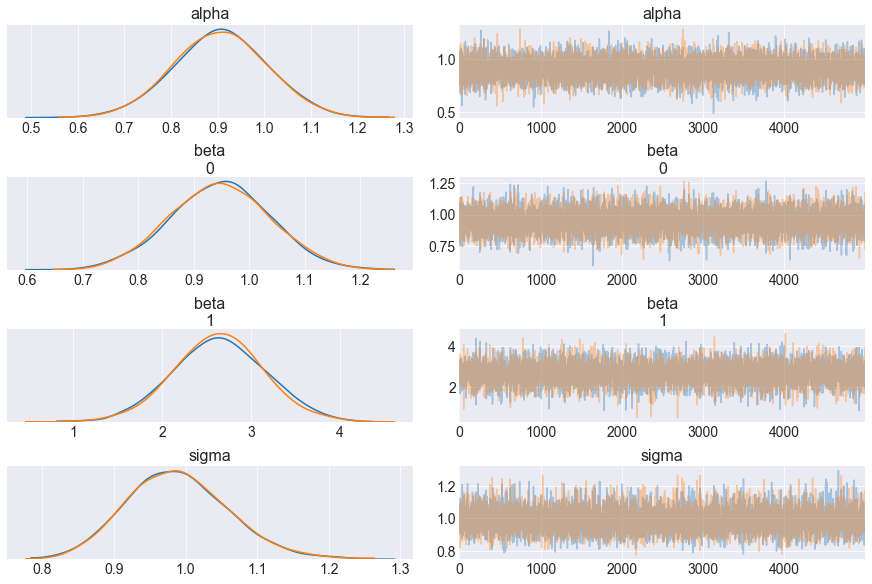

In [64]:
pm.traceplot(trace2);

In [65]:
pm.summary(trace).round(2)

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.71,1.10,1160.38,1.0
beta__0,0.95,0.09,0.00,0.75,1.12,1815.64,1.0
beta__1,2.63,0.52,0.01,1.67,3.67,1409.75,1.0
sigma,0.99,0.07,0.00,0.87,1.15,1636.45,1.0


In [66]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.911234,0.099604,0.002826,0.714663,1.102544,1160.380389,0.999491
beta__0,0.946993,0.093107,0.002358,0.751551,1.117188,1815.641553,1.000535
beta__1,2.627142,0.515589,0.014653,1.671663,3.672166,1409.751774,1.000161
sigma,0.990739,0.071336,0.001640,0.865669,1.145815,1636.452526,0.999086


so summary is a function within stat.py module.
we can guess that we do not notate module name on it's relative naming (package.module.function?)
Or maybe not. if so, they I can say that packages (including subpackages) are notated before a class, function or field from a unnotated module. 

sample is a function, and sampling is a module. One more evidence.

In [67]:
np.array

<function numpy.array>

array is a function/method, and numpy is a package for sure

In [68]:
# how to check the location of an object defined!!!!!!!!
import inspect
inspect.getmodule(np.array).__file__

'/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'

Okay so array is a fucntion that is included in __init__.py module which all packages has to be defined as a package. I am pretty sure that we do not denote module names for objects since if not we must have been seen .__init__. frequently! For now I will believe all the names before 'dot' are package names. 

Now let's see what the hack is the blue and red lines; first assumption is that they are from the different chains.


In [69]:
with basic_model: # basic model is the linear regression model that we fit earlier
    trace3 = pm.sample(draws=500, chains =3)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1043.09draws/s]


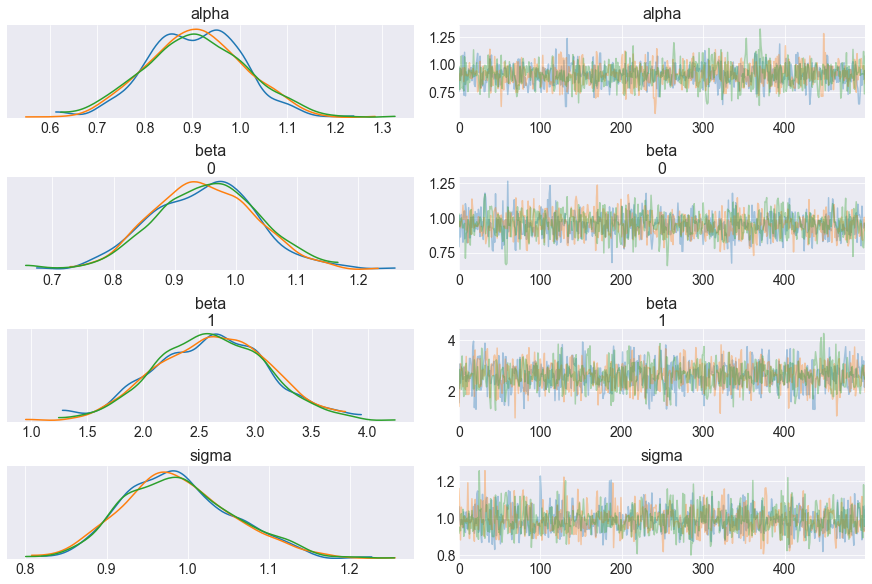

In [70]:
pm.traceplot(trace3);

Almost surely each color line is from one chain. 
The right column contains the samples of the Markov chain plotted in sequential order. Hence the X axis has values up to 500 as we generated 500 samples.

In [71]:
pm.summary(trace2).round(2)

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.72,1.11,9283.21,1.0
beta__0,0.95,0.09,0.00,0.77,1.12,10340.59,1.0
beta__1,2.64,0.51,0.01,1.67,3.71,7468.93,1.0
sigma,0.99,0.07,0.00,0.85,1.12,8343.05,1.0


The true values of the parameters are 1, 1, 2.5 and 1 following the row order.
# Case study 1: Stochastic volatility
In this example of stock market volatility, the variable is non-normal haxing 400 parameters. NUTS has faster performance than Metropolis-Hastings which will be bogged down.
## Model
There are some days when the asset price is fluctuating a lot (high variance), while the other days the price is somewhat stable. We assume there is a latent variable that controls the variablity of the variability.
\begin{split}\begin{aligned}
  \nu &\sim exp(0.1) \\
  \sigma &\sim exp(50) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^2) \\
  log(r_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}\end{split}

Here, for each day the latent volatility variable affects the price variable $r_{i}$, where degree of freedom and the variable of latent varible $s_{i}$ are from exponential variable **which I can't understand the justification. Moreover, can degree of freedom can be a non integer positive number?** 

In [103]:
import pandas as pd

returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)
returns2 = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=False, index_col=0)
returns3 = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True)
returns4 = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=False)

In [124]:
print(returns.dtypes, returns2.dtypes, returns3.dtypes, returns4.dtypes, sep="\n\n")
# I do not see the point of parse_dates argument yet...

change    float64
dtype: object

change    float64
dtype: object

date       object
change    float64
dtype: object

date       object
change    float64
dtype: object


In [125]:
len(returns)

401

In [129]:
returns['change']

date
2008-05-02    0.002764
2008-05-05   -0.004805
2008-05-06    0.008663
2008-05-07   -0.017811
2008-05-08   -0.002580
                ...   
2009-11-25    0.003514
2009-11-27   -0.016251
2009-11-30    0.003377
2009-12-01    0.012370
2009-12-02   -0.000449
Name: change, Length: 401, dtype: float64

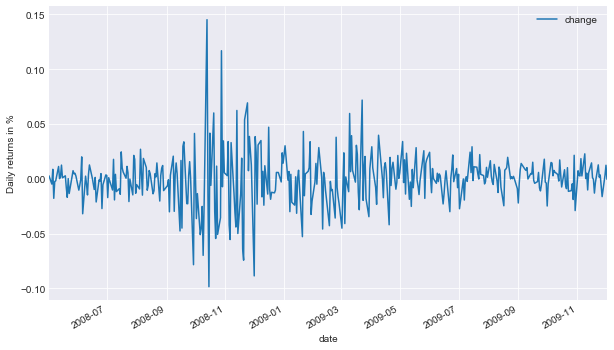

In [126]:
returns.plot(figsize=(10,6))
plt.ylabel('Daily returns in %');

Note that this is just % of increase-decrease relation (returns).
## Model Specification
Starting points for variable is not provided anymore, but we can set 'test value' using testval argument. It replaces the default test values such as mean, median and mode, and it can also be used as the starting points.

The Gaussian Random Walk gives prior distrubution to the vector of latent volatilities. 
The length of the vector is set by shape argument. It generates a vector of random walk determined by Gaussian distribution. 

Reminder:  
\begin{split}\begin{aligned}
  \nu &\sim exp(0.1) \\
  \sigma &\sim exp(50) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^2) \\
  log(r_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}\end{split}

In [134]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', lam = 1/10., testval=5.)
    sigma = pm.Exponential('sigma', lam= 1/0.02, testval = .1)
    
    # it's a vector
    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns))
    
    # so this is another vector 
    volatility_process = pm.Deterministic('volatimity_process', var = pm.math.exp(-2*s)**0.5)
    # this is a variance of our log(r) but log(r) is asking standard deviation for it's argument: **0.5
    
    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns['change'])
    

In [139]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:23<00:00, 34.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


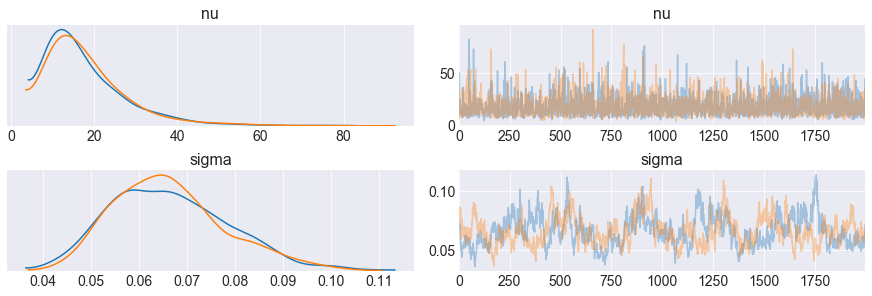

In [140]:
pm.traceplot(trace, var_names=['nu','sigma']);

I guess different paramatrization is considered inside of specification; we used rate but the plot is for scale (inverse of rate).
nu seems to close to 10, and sigma seems to close to 0.065 which is far away from 0.02.

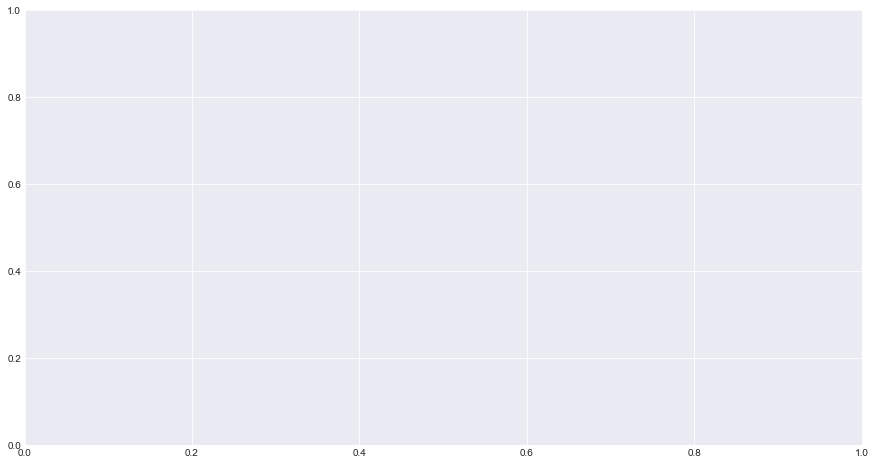

In [177]:
fig, ax=plt.subplots(figsize=(15,8))
# when you run this you get figure object (canvas) showing

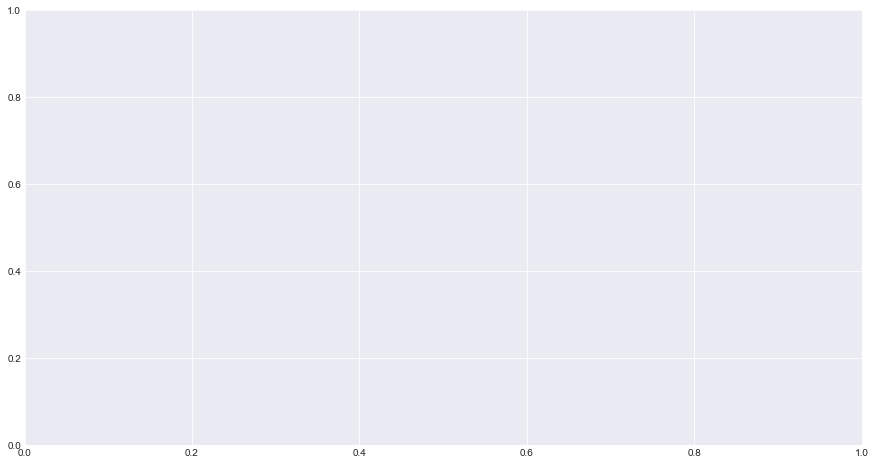

In [178]:
fig # showing the same canvas again

In [179]:
ax # it shows the empty Axes object at the location where it's placed at memory. (it's maybe a hash or whatever)

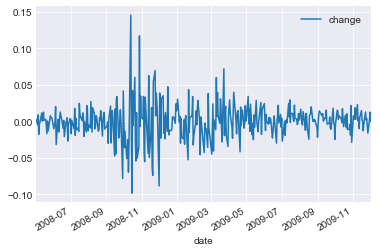

In [185]:
# fig
ax
returns.plot()
# This is the plot we can get directly from the data frame of Pandas 

In [186]:
returns.plot(ax=ax)
# For the ax argument we give 'the ax' we created from the huge canvas from plt.subplots(figsize=(15,8))b

In [187]:
fig
ax
returns.plot(ax=ax)

It is weird that the two cells above is not showing any plots.
### **why?**

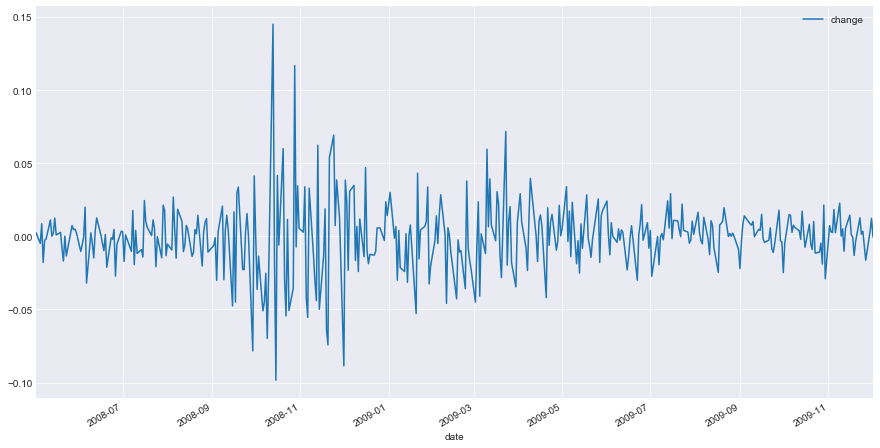

In [188]:
fig, ax = plt.subplots(figsize=(15,8))
returns.plot(ax=ax)

In [190]:
returns.index

DatetimeIndex(['2008-05-02', '2008-05-05', '2008-05-06', '2008-05-07',
               '2008-05-08', '2008-05-09', '2008-05-12', '2008-05-13',
               '2008-05-14', '2008-05-15',
               ...
               '2009-11-18', '2009-11-19', '2009-11-20', '2009-11-23',
               '2009-11-24', '2009-11-25', '2009-11-27', '2009-11-30',
               '2009-12-01', '2009-12-02'],
              dtype='datetime64[ns]', name='date', length=401, freq=None)

In [195]:
trace.points

<bound method MultiTrace.points of <MultiTrace: 2 chains, 2000 iterations, 6 variables>>

In [222]:
trace['s'].shape

(4000, 401)

In [218]:
np.exp(trace['s',::5].T).shape

(401, 800)

In [220]:
returns.index.shape

(401,)

We generated 2000 samples, and two chains there, so s have 8000 samples for each date.
By using extended slice, ::5, we only have subset (sampling) of them and 8000/5=800 observations.
Transposing it, so now each row is one date while each column is one sample on the date.
a "CN" color spec, i.e. 'C' followed by a number, which is an index into the default property cycle.

In [227]:
fig, ax

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3bfb6f90>)

In [228]:
returns.plot(ax=ax)

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


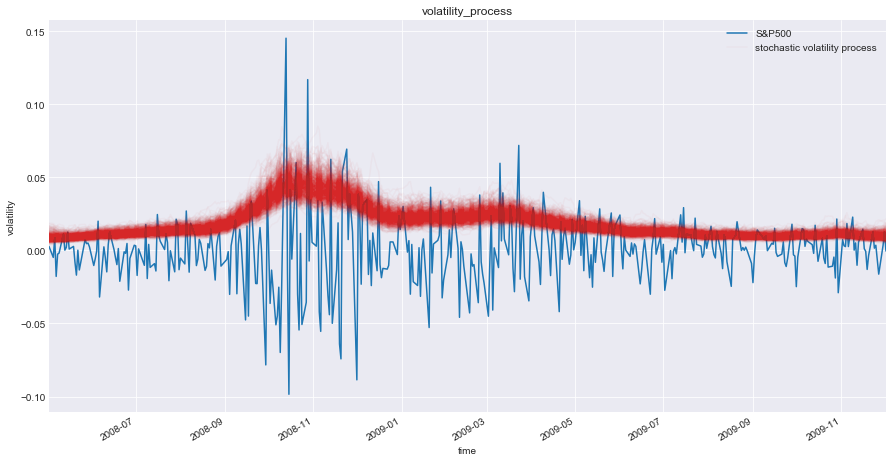

In [150]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3ㅠㅠ', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

.py requires plt.show()  
To use the library interactively with Ipython interface,   
%matplotlib first. Then,  
updating active figures from Ipython requires plt.draw().  
If you are using jupyter notebook,   
%matplotlib inline   
will give you static images embedded in the notebook.  


In [152]:
inspect.getmodule(plt).__file__

'/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'

    Note:   
matplotlib is a library (or a package) that is a kind of based on MATLAP lauguage. From the library we import pyplot module, and name it as plt.   
Figure class is top level object allowing easy manipulation (it's entire graphic). Whole shebang (뼈대, 골격).
But what you are actually seeing as your plot is not the figure. It's a subplot (or axes object) on top of the figure.  
The axes class is lower level object and the entire graph you see. Stop thinking of it as the vertical (y) or horizontal (x) lines.  
So ax=ax in the argument means that we already have an ax object, so we will just use the one not making a new one from the function that we are on.  
subplot(111) means 1x1 grid put in the first section. 2x1 grid means 2 long plots in one column.  
Frist section, from the thrid 1, means the first element. 211 means the 1 by 1 place, while 212 means the second place, 2 by 1.  
The basic way is to make figure first, (fig=plt.figure()), and then on the canvas, the figure, add the plots:
ax1 = fig.add_subplot(2,2, (1,2))  
ax2 = fig.add_subplot(224)  
In short, they are all done by   
fig, (ax1, ax2) = fig.subplots(1,2). Note that the axes are dishes on the figure table. 